# 0.0 Imports

In [1]:
import warnings

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

## 0.1 Load data

### Feature Description based on the Project Plan

Referring to our [project plan](../docs/planning.md), it is crucial to understand the definitions of the dataset features. As a comprehensive description document is absent, we'll provide inferred definitions, keeping in mind that our planning takes into account movies in both script-drafting and filming stages.

**Dataset Features**:
- `show_id`: Unique identifier for the media.
- `type`: Media type.
- `title`: Media title or name.
- `director`: The directing team responsible for the media.
- `cast`: Cast members involved.
- `country`: Planned country for filming or production.
- `date_added`: Date when the media was added to the database.
- `release_year`: Year the media was released.
- `rating`: Evaluation or rating score.
- `duration`: Media runtime or duration.
- `listed_in`: Categories or genres the media falls under.
- `description`: Brief synopsis of the media.

In [2]:
netflix_data = catalog.load("netflix_data")

                    INFO     Loading data from 'netflix_data' (ExcelDataSet)...                 ]8;id=109965;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=773626;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

- Ideally, we could separate test data to simulate the production period, but due to the amount of data, we will use the cross-validation technique in the next steps.

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [28, 12]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None

notebook_settings()

# 1.0 Data Description

In [4]:
data_description = netflix_data.copy()
data_description.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.000,41.000,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.000,52.000,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.000,82.000,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.000,64.000,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.000,57.000,99 min,Comedies,When nerdy high schooler Dani finally attracts...


## 1.1 Data Dimension

In [5]:
print(f'Number os rows: {data_description.shape[0]}')
print(f'Number os columns: {data_description.shape[1]}')

Number os rows: 6234
Number os columns: 12


## 1.2 Check NA

In [6]:
data_description.isna().sum() / data_description.shape[0] * 100


show_id         0.000
type            0.000
title           0.000
director       31.601
cast            0.016
country         0.016
date_added      0.192
release_year    0.016
rating          0.016
duration        0.016
listed_in       0.016
description     0.016
dtype: float64

## 1.3 Fillout NA

- **director**: as it represents a considerable amount it is important to replace this data, some approaches to disregard are:
    - collecting this data from an external source since it requires a lot of effort
    - filling in via an algorithm would not be the best approach because the algorithm will try to fill in based on the directors in the database, but there may be a situation where the director was not initially mapped, and it also requires a lot of effort to develop an ml pipeline.
    
That said, we do have the option of creating a `others_directors` label, which preserves the data and allows us to analyze this new label to see if there are any patterns.

In [7]:
data_description['director'].fillna('others_directors', inplace=True)

- The other columns have very little data, but for our reality where data is scarce we will try to preserve these rows

In [8]:
# These columns have characteristics that may be related to the type of media, 
# so let's extract the most frequent information and substitute
columns_to_process = ['duration', 'listed_in', 'country']
modes = data_description.groupby('type')[columns_to_process].apply(lambda x: x.mode().iloc[0])

for column in columns_to_process:
    data_description[column] = (data_description.groupby('type')[column]
                                .transform(lambda x: x.fillna(modes.loc[x.name, column])))

# The release_year, date_added and rating columns can be replaced by the average, although this situation 
# does not add variability the percentage is not significant
data_description['release_year'] = data_description['release_year'].fillna(data_description['release_year'].mean())
data_description['date_added'] = data_description['date_added'].fillna(data_description['date_added'].mean())
data_description['rating'] = data_description['rating'].fillna(data_description['rating'].mean())

# The cast and description columns are unique to each medium and therefore 
# make no sense to replace them, but we can create a specific label
data_description['cast'] = data_description['cast'].fillna('others_cast')
data_description['description'] = data_description['description'].fillna('others_description')

data_description.isna().sum() / data_description.shape[0] * 100


show_id        0.000
type           0.000
title          0.000
director       0.000
cast           0.000
country        0.000
date_added     0.000
release_year   0.000
rating         0.000
duration       0.000
listed_in      0.000
description    0.000
dtype: float64

## 1.4 Data Types

In [9]:
data_description.dtypes


show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year           float64
rating                 float64
duration                object
listed_in               object
description             object
dtype: object

In [10]:
data_description['release_year'] = data_description['release_year'].astype('int64')
data_description['rating'] = data_description['rating'].astype('int64')
data_description['date_added'] = pd.to_datetime(data_description['date_added'])

data_description.dtypes


show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                   int64
duration                object
listed_in               object
description             object
dtype: object

## 1.6 Descriptive Statistical

In [11]:
df_aux = data_description.copy()

num_attributes = df_aux.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_aux.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [12]:
# Central tendency and Dispersion
range_values = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
statistic_metric = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# Concatenate
metrics = pd.concat([range_values, statistic_metric]).T.reset_index()
metrics.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics = metrics[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

metrics

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,show_id,247747.000,81235729.000,80987982.000,76703679.320,80163367.000,10942964.650,-5.151,30.335
1,release_year,1925.000,2020.000,95.000,2013.370,2016.000,8.768,-3.685,18.137
2,rating,0.000,97.000,97.000,64.128,68.000,19.012,-1.958,4.300


As we have few numerical columns, we can make more general comments:
- **release_year**: shows by the average and skew a growing media over the decades, which demonstrates the strengthening of the industry in the long term.
- **rating**: although the expected range is 0 to 100, we have values of up to 97, which can limit the prediction of models such as tree-based models, supposing that Netflix wanted to create content with a rating of 100, these models would not be suitable.
    - The average rating shows a range of 64 in the rating, this doesn't necessarily mean that a movie has to be good when the rating is above 64, but there are plenty of movies that can be grouped in this range, data on the number of people who rate and billing can help to understand the popularity in order to make a better judgment in the future of what media is considered acceptable.

### 1.6.2 Categorical Attributes

In [13]:
# checking data variation
cat_attributes.apply(lambda x: x.unique().shape[0])


type              2
title          6172
director       3301
cast           5471
country         555
date_added     1190
duration        201
listed_in       461
description    6226
dtype: int64

- As the cardinality is high, we'll use the boxplot to type and analyze some of the most frequent `country` and `listed_in` data.

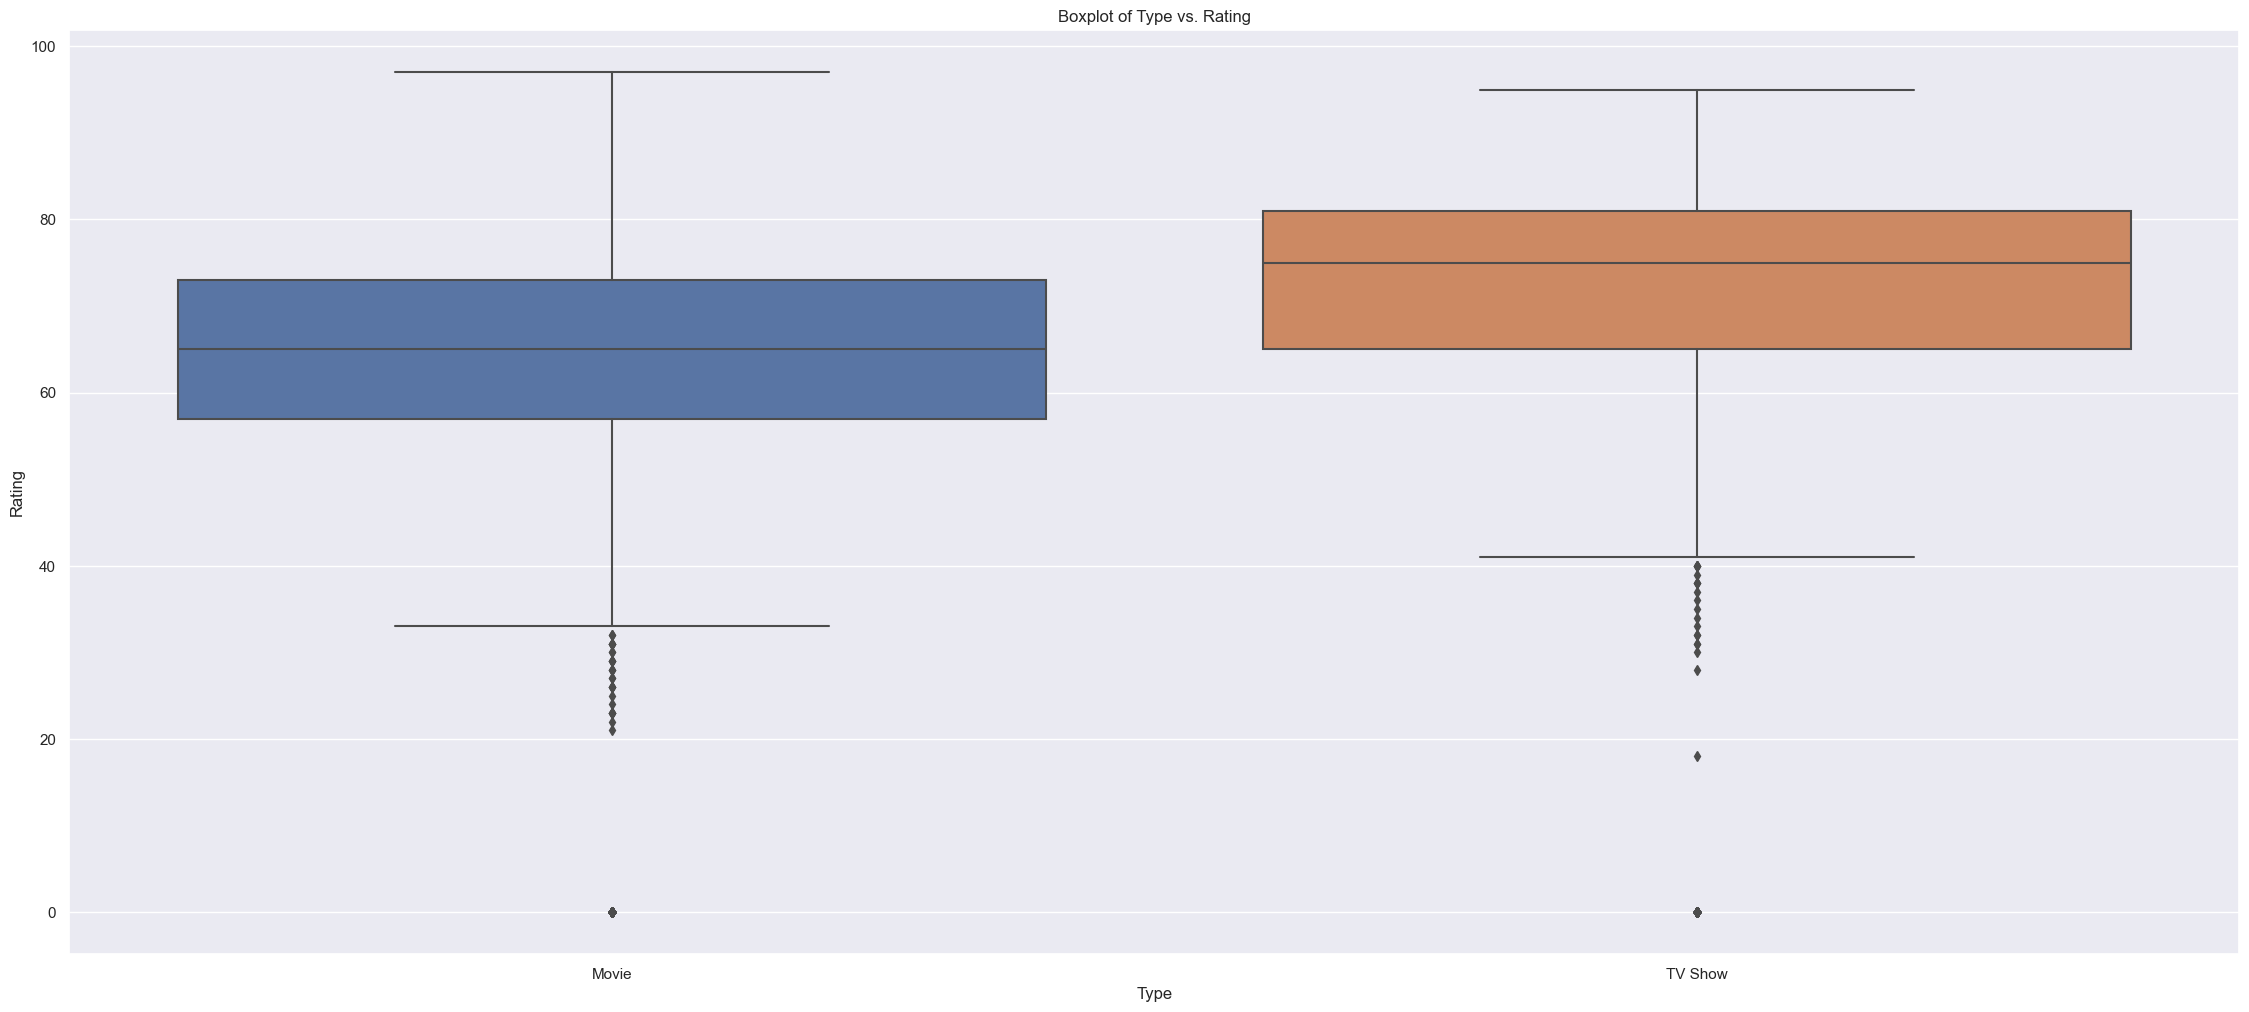

In [14]:
sns.boxplot(x='type', y='rating', data=data_description)
plt.title('Boxplot of Type vs. Rating')
plt.xlabel('Type')
plt.ylabel('Rating');

- In the boxplot it's interesting to see how the median and percentiles are different, here we have a similar format, but TV shows seem to have improved ratings. It's important to note that there may be potential in the TV data, but as it's not the focus of the problem we won't focus on it.

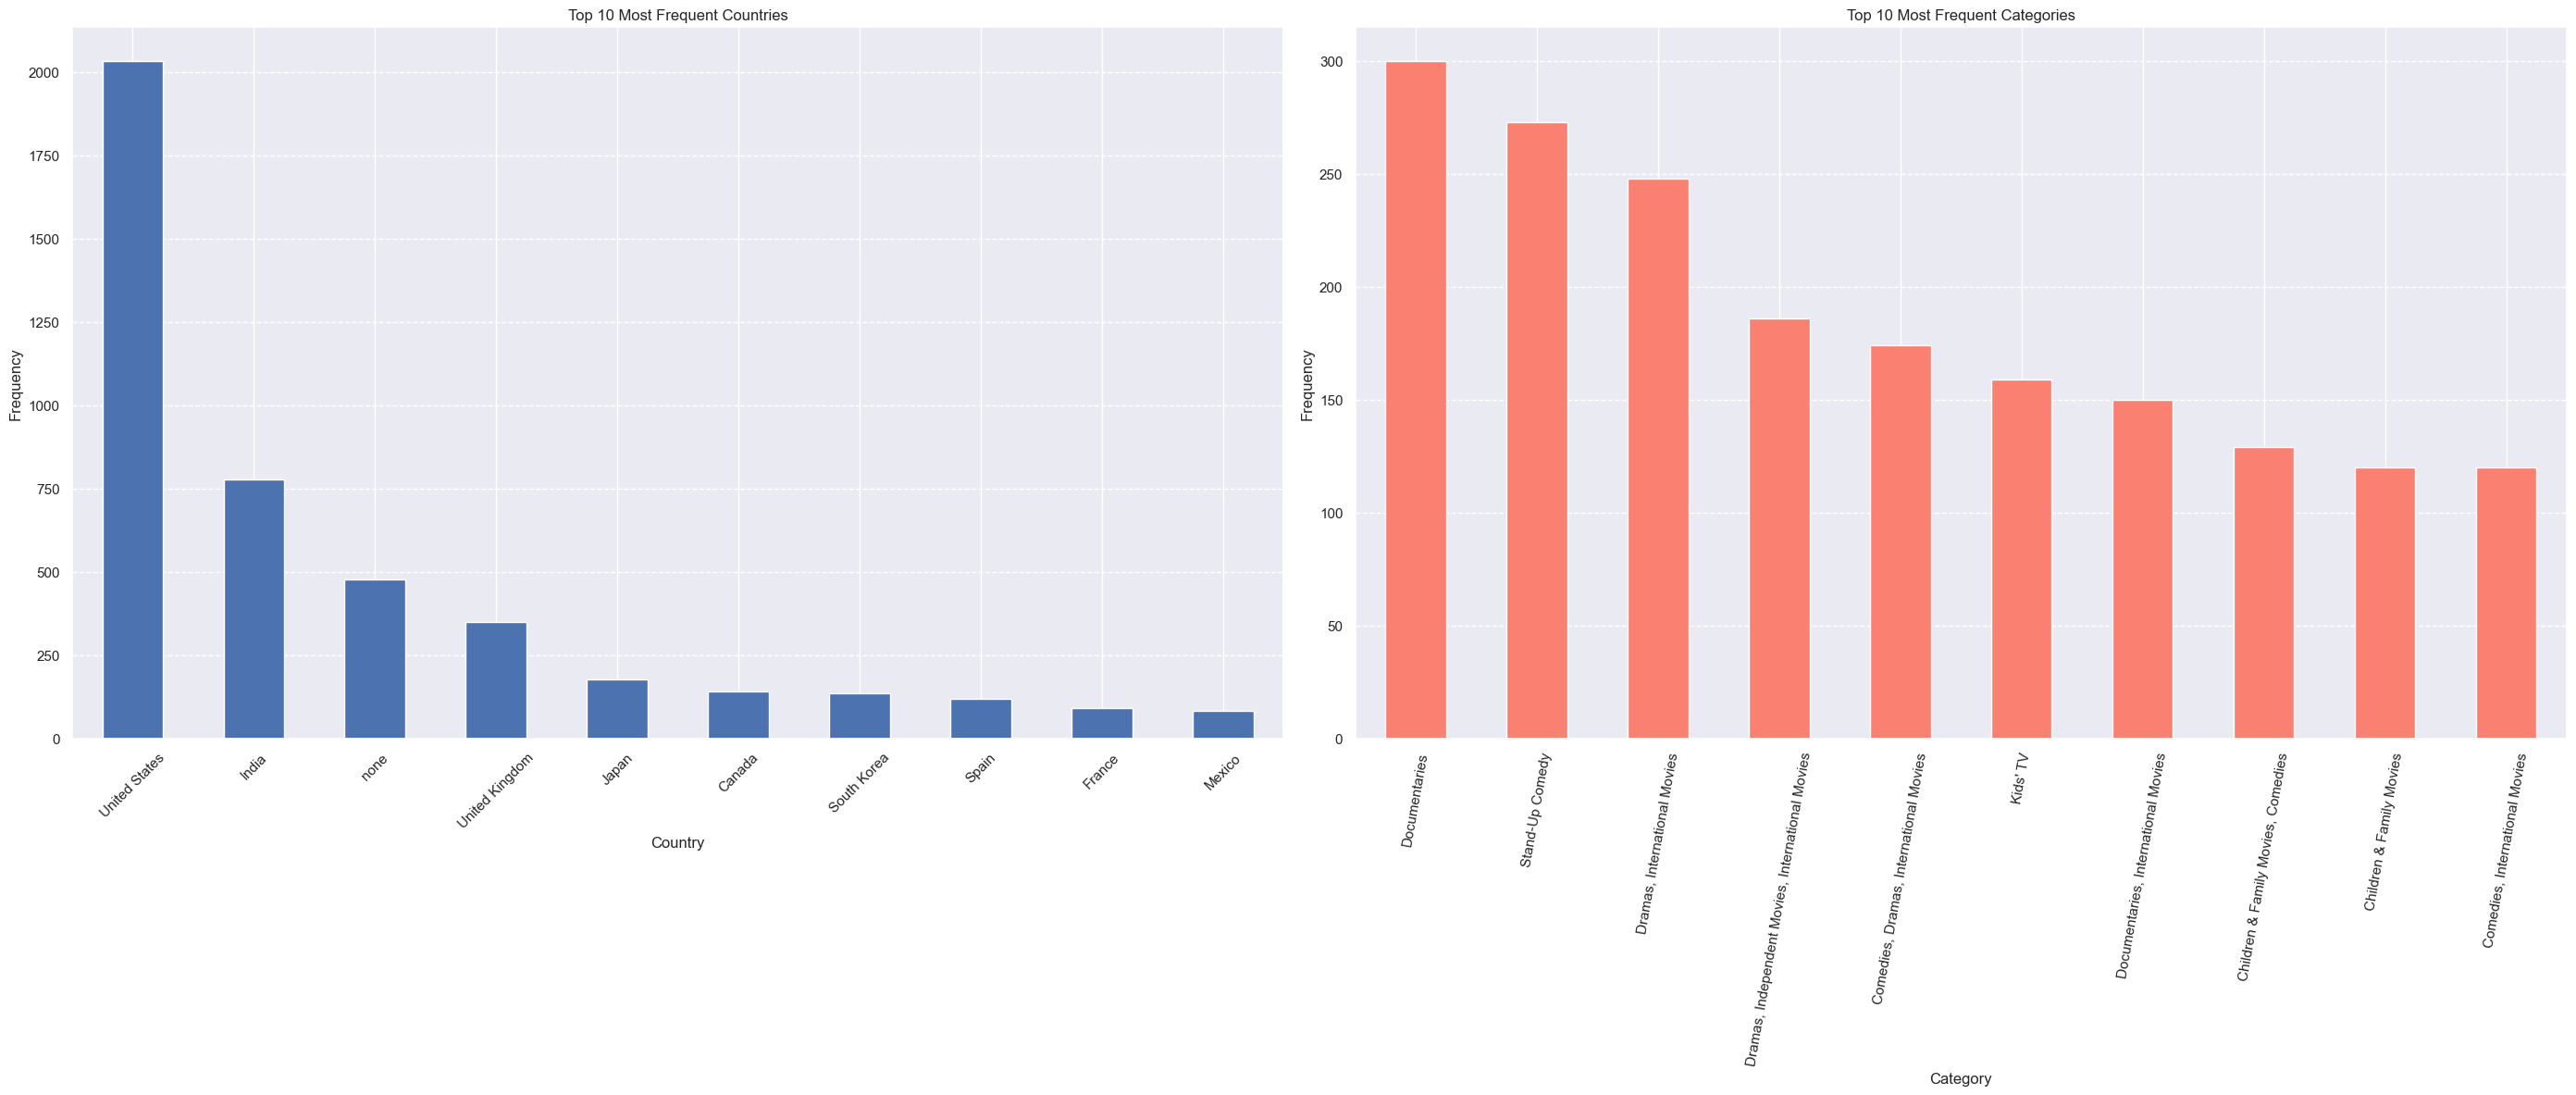

In [15]:
fig, axes = plt.subplots(1, 2)

# Top 10 Countries
top_countries = cat_attributes['country'].value_counts().head(10)
top_countries.plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Most Frequent Countries')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--')

# Top 10 Categories
frequencies = cat_attributes['listed_in'].value_counts().head(10)
frequencies.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Top 10 Most Frequent Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=80)
axes[1].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

- The first graph shows the accumulation of media in the USA, which demonstrates Hollywood's strength
- In the second graph we have something more balanced, it is important to note that we are analyzing the most frequent cases and this can indicate the level of public demand, in this sense documentaries that in principle should be for niche audiences are actually a significant amount of the data, let's keep in mind that the data shows consumption on Netflix and does not correspond to the population.

In [16]:
catalog.save("data_description", data_description)

[09/23/23 10:13:28] INFO     Saving data to 'data_description' (CSVDataSet)...                  ]8;id=871544;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=266436;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\